This notebook will explore various temperature values for the CEBRA model to produce reasaonable embeddings for simple inputs.

In [1]:
! pip install 'cebra[dev,demos]' 

  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached nbconvert-7.16.2-py3-none-any.whl (257 kB)
  Using cached pylint-3.1.0-py3-none-any.whl (515 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached yapf-0.40.2-py3-none-any.whl (254 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.7 MB/s eta 0:00:00
  Using cached isort-5.13.2-py3-none-any.whl (92 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.6/206.6 kB 32.1 MB/s eta 0:00:00
  Using cached pytest-8.1.1-py3-none-any.whl (337 kB)
  Using cached pytest_benchmark-4.0.0-py3-none-any.whl (43 kB)
  Using cached pytest_xdist-3.5.0-py3-none-any.whl (42 kB)
  Using cached pytest_timeout-2.3.1-py3-none-any.whl (14 kB)
  Using cached pytest_sphinx-0.6.0-py3-none-any.whl (10 kB)
  Using cached tables-3.8.0.tar.gz (8.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wh

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
from scipy.integrate import solve_ivp
import cebra.datasets
from cebra import CEBRA
import d_library as dl

from matplotlib.collections import LineCollection
import pandas as pd

/Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/lib/python3.11/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


## Define Data

The lorenz attractor and a simple 2D circle will be used as inputs to the CEBRA model to test the performance CEBRA.

Let's start with the 2D circle

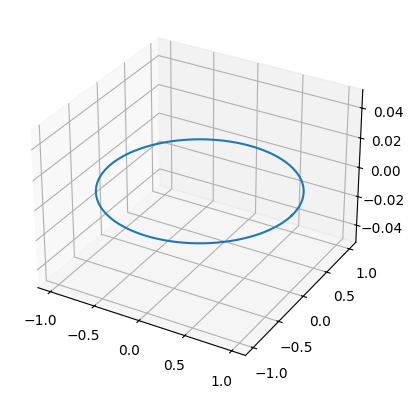

(100, 3)

In [2]:
%matplotlib inline
circle = dl.make_circle()
dl.plot_circle(circle[:,0], circle[:,1])
circle.shape

Now let's get our second input: the Lorenz attractor

In [3]:
xyz = dl.make_lorenz()

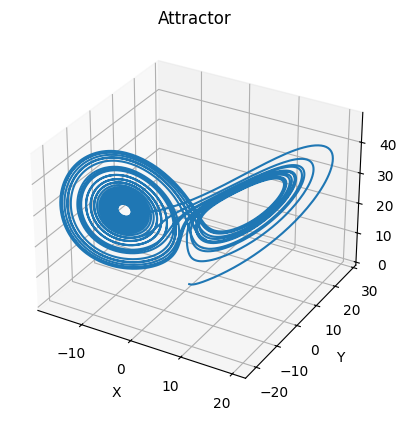

In [5]:
dl.plot_lorenz(xyz)

In [52]:
# reshape it for use with cebra
lorenz_obj = xyz.reshape(10000,3)
lorenz_obj.shape

(10000, 3)

## Fixed Temperature Model:

In [58]:
iterations = 2000

In [88]:
# function to get an embedding    
def base_embed(input, temp=1, dimension=3, lr = 0.01):
# build CEBRA time model
    fixed_temp_model = CEBRA(model_architecture='offset1-model',
                            batch_size=512,
                            learning_rate=int(lr),
                            temperature=int(temp),
                            output_dimension = int(dimension),
                            max_iterations=iterations,
                            delta=0.5,
                            distance='euclidean',
                            conditional='delta',
                            device='cuda_if_available',
                            num_hidden_units=64,
                            verbose=True,
                            time_offsets=1)

    fixed_temp_model.fit(input)
    embedding = fixed_temp_model.transform(input)
    return fixed_temp_model, embedding

In [89]:
# get the embeddings
ft_model_c, ft_embedding_c = base_embed(circle, lr=0.1)
ft_model_l, ft_embedding_l = base_embed(lorenz_obj, lr=0.01)

  0%|          | 0/2000 [00:00<?, ?it/s]

pos:  0.0000 neg:  6.2313 total:  6.2313 temperature:  1.0000: 100%|██████████| 2000/2000 [00:24<00:00, 82.44it/s]
pos:  0.0030 neg:  5.2891 total:  5.2921 temperature:  1.0000: 100%|██████████| 2000/2000 [00:23<00:00, 86.69it/s]


<Axes3D: title={'center': 'Lorenz Attractor'}>

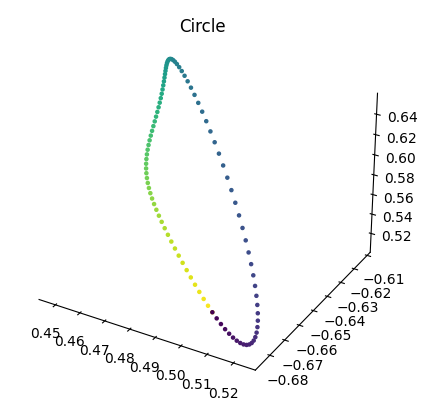

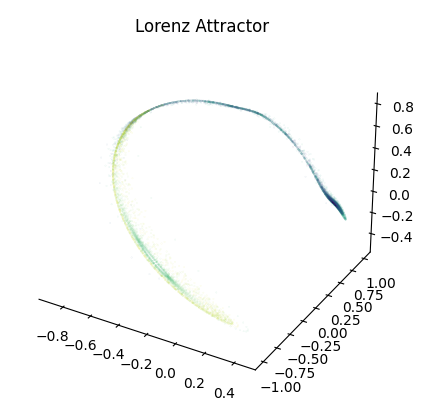

In [90]:
# plot the embeddings
cebra.plot_embedding(ft_embedding_c, embedding_labels='time', markersize=5, alpha=1, title='Circle')
cebra.plot_embedding(ft_embedding_l, embedding_labels='time', markersize=0.001, alpha=1, title='Lorenz Attractor')

## Learnable temperature model

Setting temperature_mode to auto will make the temperature to be optimized during the training of a model.

min_temperature is the lower bound for the tempearture. If not specified, min_temperature is set to asymptotic 0. (from CEBRA documentation)

In [91]:
# function to get an embedding    
def base_embed_l(input, temp=1, dimension=3, lr = 0.01):
# build CEBRA time model
    fixed_temp_model = CEBRA(model_architecture='offset1-model',
                            batch_size=512,
                            learning_rate=int(lr),
                            temperature_mode='auto',
                            min_temperature=0.1,
                            delta=0.5,
                            output_dimension = int(dimension),
                            max_iterations=iterations,
                            distance='euclidean',
                            conditional='delta',
                            device='cuda_if_available',
                            num_hidden_units=64,
                            verbose=True,
                            time_offsets=1)

    fixed_temp_model.fit(input)
    embedding = fixed_temp_model.transform(input)
    return fixed_temp_model, embedding

In [92]:
# get the embeddings
lt_model_c, lt_embedding_c = base_embed_l(circle, lr=0.1)
lt_model_l, lt_embedding_l = base_embed_l(lorenz_obj, lr=0.01)

  0%|          | 0/2000 [00:00<?, ?it/s]

pos:  0.0000 neg:  6.2223 total:  6.2223 temperature:  1.0000: 100%|██████████| 2000/2000 [00:24<00:00, 81.84it/s]
pos:  0.0011 neg:  5.4652 total:  5.4663 temperature:  1.0000: 100%|██████████| 2000/2000 [00:24<00:00, 80.50it/s]


<Axes3D: title={'center': 'Lorenz Attractor'}>

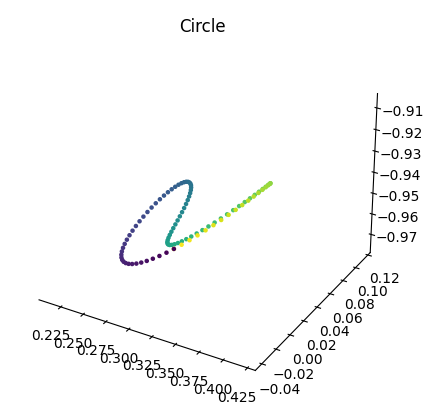

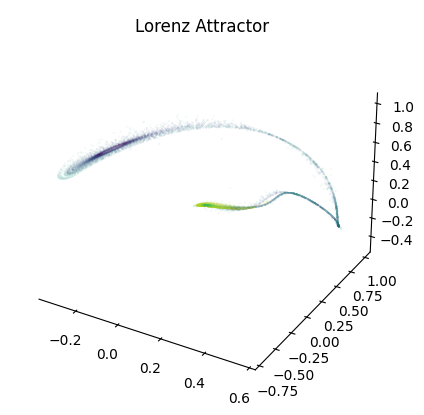

In [93]:
# plot the embeddings
cebra.plot_embedding(lt_embedding_c, embedding_labels='time', markersize=5, alpha=1, title='Circle')
cebra.plot_embedding(lt_embedding_l, embedding_labels='time', markersize=0.001, alpha=1, title='Lorenz Attractor')

## Visualize the Loss and the temperature

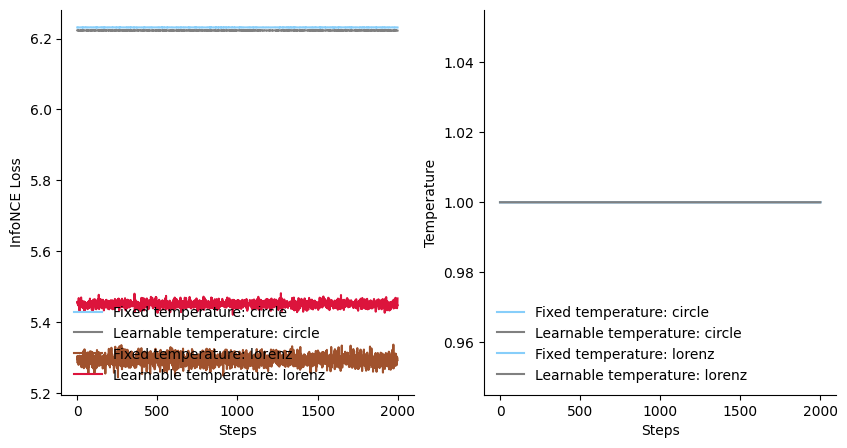

In [94]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)

ax1.plot(ft_model_c.state_dict_['loss'], c='lightskyblue', label='Fixed temperature: circle')
ax1.plot(lt_model_c.state_dict_['loss'], c='gray', label = 'Learnable temperature: circle')

ax1.plot(ft_model_l.state_dict_['loss'], c='sienna', label='Fixed temperature: lorenz')
ax1.plot(lt_model_l.state_dict_['loss'], c='crimson', label = 'Learnable temperature: lorenz')

ax1.set_ylabel('InfoNCE Loss')
ax1.set_xlabel('Steps')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.legend(loc = 'lower left', frameon = False)


ax2= plt.subplot(122)
ax2.plot(ft_model_c.state_dict_['log']['temperature'], c='lightskyblue', label='Fixed temperature: circle')
ax2.plot(lt_model_c.state_dict_['log']['temperature'], c='gray', label = 'Learnable temperature: circle')

ax2.plot(ft_model_l.state_dict_['log']['temperature'], c= 'lightskyblue', label='Fixed temperature: lorenz')
ax2.plot(lt_model_l.state_dict_['log']['temperature'], c='gray', label = 'Learnable temperature: lorenz')


ax2.set_ylabel('Temperature')
ax2.set_xlabel('Steps')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.legend(loc = 'lower left', frameon = False)

Rerun this notebook and change some of the parameters so that the loss converges: start with the model architecture.